# Calculating Excited states' energy

## Overview
In this notebook, we demonstrate the calculation of both ground and excited state energies using CASCI, CCSD, and CISD within the PySCF. <br>
We illustrate the conceptual difference between Configuration Interaction (CI) and Coupled Cluster methods. <br>


Then we want calculate everything in QSCI framework. <br>


After getting CCSD parameters, we can use it as the ground state parameter values for the UCCSD, We then apply QSCI to diagonalize the selected configuration space and estimate the ground state energy. <br> 


After obtaining the ground state energy, we extend to excited states by designing a cost function which can extract excited states sequentially through minimizing the total energy. <br>


Finally, we compare the results obtained from exact classical simulations with those from quantum computation.

# Generate Hamiltonian
In this tutorial, we demonstrate how to construct a qubit Hamiltonian for a molecule.
We will use `OpenFermion`, `PySCF`, and `Quri-Parts`.

- Select the molecule you want to study. (In our case: `Azobenzene`)
- Use `PySCF` to build this molecule an object and compute for it's orbitals and Hartree–Fock energy.
- Define Complete Active Space (CAS) to focus on sub-system of the entire molecule to make computation easier.
- Compute molecular integrals within the chosen active space, build the Fermionic Hamiltonian and map it to a Qubit Hamiltonian (default: Jordan–Wigner mapping).

In [1]:
from openfermion.chem import geometry_from_pubchem
from quri_parts.chem import cas
from quri_parts.pyscf.mol import get_spin_mo_integrals_from_mole
from quri_parts.openfermion.mol import get_qubit_mapped_hamiltonian
from pyscf import gto, scf, mcscf, cc, ci

atom = geometry_from_pubchem("azobenzene")
mole = gto.M(atom=atom) 
mf = scf.RHF(mole).run() 

active_space = cas(4, 4)

hamiltonian, mapping = get_qubit_mapped_hamiltonian(
    *get_spin_mo_integrals_from_mole(mole, mf.mo_coeff, active_space)
)

converged SCF energy = -562.053344724961


## Compute exact excited state by CASCI with PySCF.

### Complete Active Space Configuration Interaction (CASCI)
**Configuration Interaction (CI)** is one of a **post-Hartree–Fock method** for solving the electronic Schrödinger equation within the Born-Oppenheimer approximation for a quantum chemical multi-electron system. <br>
It goes beyond the single-determinant Hartree–Fock approximation by including **electron correlation effects** through a variational wave functions, which is written as a **linear combination of configuration state functions (CSFs)**,  <br>
$\Psi = \sum_{I} c_I \Phi_I$
where:
- $\Phi_I$ are many-electron basis states (determinants or CSFs),
- $c_I$ are variational coefficients optimized by diagonalizing the Hamiltonian.


### CASCI
**CASCI** performs a full CI but only **within the chosen active space**: <br>
- Inactive orbitals (always doubly occupied) and virtual orbitals (always empty) are frozen,  
- Active orbitals allow the chosen number of active electrons to be distributed in all possible ways.  

This makes CASCI to capture the **static (strong) correlation** among active orbitals.


### PySCF Implementation
In PySCF, `mcscf.CASCI` constructs the CASCI solver.  
Setting `mc.fcisolver.nstates = N` requests multiple low-lying excited states by diagonalizing the Hamiltonian within the active space.


In [40]:
mc = mcscf.CASCI(mf, active_space.n_active_orb, active_space.n_active_ele)
mc.fcisolver.nstates = 6 # Compute ground state + 5 excited states
mc.kernel(verbose=0)
print(mc.e_tot*27.21, "eV")

CASCI state   0  E = -562.057671219960  E(CI) = -2.20745364895095  S^2 = 0.0000000
CASCI state   1  E = -561.829824515089  E(CI) = -1.97960694408050  S^2 = 2.0000000
CASCI state   2  E = -561.812652554590  E(CI) = -1.96243498358137  S^2 = 0.0000000
CASCI state   3  E = -561.752682574615  E(CI) = -1.90246500360570  S^2 = 2.0000000
CASCI state   4  E = -561.747970360661  E(CI) = -1.89775278965180  S^2 = 2.0000000
CASCI state   5  E = -561.740607983116  E(CI) = -1.89039041210685  S^2 = 0.0000000
[-15293.5892339  -15287.38952506 -15286.92227601 -15285.29049286
 -15285.16227351 -15284.96194322] eV


# Compute ground state by UCCSD
## Coupled Cluster Singles and Doubles (CCSD)
**Coupled cluster (CC)** is another **post-HF method** in Quantum chemistry. <br>
Unlike CI takes linear combination configuration state functions, CC uses the exponential cluster operator for considering electron correlation, <br>
$\Psi = e^T \Phi$ <br>
where:
- T: Cluster operator.
- $\Phi$: Slater determinant of CI.

### Cluster operator
**Cluster operator (T)** is written in the form of $T = T_1 + T_2 + T_3 \dots$, where $T_1$ is single excitation, $T_2$ is double excitation, etc. Which in the second quantization formalism can be written as, <br>
- $T_1 = \sum_{i, a} t_i^a a^\dagger_a a_i$, 
- $T_2 = \frac{1}{4} \sum_{ij, ab} t_{ij}^{ab} a^\dagger_a a^\dagger_b a_j a_i$
- $T_n = \frac{1}{(n!)^2} \sum_{i_1, \dots, i_n, a_1, \dots, a_n} a^\dagger_{a_1} \dots a^\dagger_{a_n} a_{i_n} \dots a_{i_1}$

In **CCSD**, only $T_1$ and $T_2$ are considerated.

The benefit of adopting exponential instead of linear combination is exponential guarentees the **size extensivity** of the solution. Take CCSD for example:
$T = T_1 + T_2$, <br>
$e^{(T_1+T_2)} = (T_1+T_2) + \frac{1}{2!} (T_1+T_2)^2 + \frac{1}{3!} (T_1+T_2)^3 ...$
Even if $T$ only includes singles and doubles ($T_1 + T_2$), the exponential generates **higher-order excitations automatically**.

### Coupled-cluster equations
Schrödinger equation: $H \ket{\Psi} = E \ket{\Psi} \to H e^T \ket{\Phi} = E e^T \ket{\Phi}$

The unknown parameters ($t_i^a, t_{ij}^{ab} \dots$) can be solved from following equation sets (CCSD):
- $\bra{\Phi_0} e^{-(T_1+T_2)} H e^{(T_1+T_2)} \ket{\Phi_0} = E$
- $\bra{\Phi_i^a} e^{-(T_1+T_2)} H e^{(T_1+T_2)} \ket{\Phi_0} = 0$
- $\bra{\Phi_{ij}^{ab}} e^{-(T_1+T_2)} H e^{(T_1+T_2)} \ket{\Phi_0} = 0$

After solving these equation sets, we get $\{t_i^a\} \ \text{and} \ \{ t_{ij}^{ab} \}$.


In [3]:
from quri_parts.chem.mol.models import OrbitalType
from quri_parts.chem.mol import ActiveSpaceMolecularOrbitals
from quri_parts.pyscf.mol import PySCFMolecularOrbitals

asmo = ActiveSpaceMolecularOrbitals(
    PySCFMolecularOrbitals(mole, mf.mo_coeff), active_space
)

forzen_orbs = [i for i in range(mole.nao) if asmo.orb_type(i) != OrbitalType.ACTIVE]

ccsd = cc.CCSD(mf, frozen=forzen_orbs).run(verbose=0)

## From CCSD to UCCSD
On a quantum computer, one uses a **unitary coupled cluster (UCC)** ansatz to maintain unitarity:

$
|\Psi_{\text{UCC}}\rangle = e^{T - T^\dagger} |\Phi_0\rangle
$

- This guarantees a **variational wavefunction**, suitable for variational quantum eigensolver (VQE) algorithms.  
- The CCSD amplitudes from classical computation are often used as **initial parameters** for the UCCSD circuit on a quantum computer.


In [4]:
from typing import Sequence
import numpy as np
import numpy.typing as npt
from quri_parts.openfermion.ansatz import TrotterUCCSD

def ccsd_param_to_circuit_param(
    uccsd: TrotterUCCSD,
    n_electrons: int,
    t1: npt.NDArray[np.complex128],
    t2: npt.NDArray[np.complex128],
) -> Sequence[float]:
    in_param_list = uccsd.param_mapping.in_params
    param_list = []

    for param in in_param_list:
        name_split = param.name.split("_")
        if name_split[0] == "s":
            _, i_str, j_str = name_split
            i, j = int(i_str), int(j_str) - n_electrons // 2
            param_list.append(t1[i, j])

        if name_split[0] == "d":
            _, i_str, j_str, a_str, b_str = name_split
            i, j, b, a = (
                int(i_str),
                int(j_str),
                int(b_str) - n_electrons // 2,
                int(a_str) - n_electrons // 2,
            )
            param_list.append(t2[i, j, a, b])
    return param_list

from quri_parts.core.state import quantum_state, apply_circuit

TROTTER_STEPS = 1
USE_SINGLES = True
REDUCE_PARAMETER = True

uccsd = TrotterUCCSD(
    active_space.n_active_orb * 2,
    active_space.n_active_ele,
    trotter_number=TROTTER_STEPS,
    use_singles=USE_SINGLES,
    singlet_excitation=REDUCE_PARAMETER,
)
param = ccsd_param_to_circuit_param(uccsd, active_space.n_active_ele, ccsd.t1, ccsd.t2)
hf_state = quantum_state(active_space.n_active_orb * 2, bits=2**active_space.n_active_ele - 1)
state = apply_circuit(uccsd, hf_state)
uccsd_bound_state = state.bind_parameters(param)


# Quantum Selected Configuration Interaction (QSCI)

With a initial parameters from CCSD, we can apply Quantum Selected Configuration Interaction ([QSCI](https://quri-sdk.qunasys.com/docs/examples/quri-algo-vm/qsci/)) to obtain ground state and ground state energy.


In [37]:
from quri_parts.qulacs.sampler import create_qulacs_general_vector_sampler
from quri_parts_qsci import qsci

BASIS_STATES = None
TOTAL_SHOTS = 10000

sampler = create_qulacs_general_vector_sampler()

eigs, _ = qsci(
    hamiltonian, [uccsd_bound_state], sampler, total_shots=TOTAL_SHOTS, num_states_pick_out=BASIS_STATES
)

print(f"Ground state energy from QSCI: {eigs[0]*27.21} eV\nExact Ground state (CASCI): {mc.e_tot[0]*27.21} eV\nError: {np.abs((mc.e_tot[0]-eigs[0]))*27.21:.2e} eV")

Ground state energy from QSCI: -15293.58482768848 eV
Exact Ground state (CASCI): -15293.58923389511 eV
Error: 4.41e-03 eV


## Excited-state cost function
After getting ground state energy, we want to go further to compute excited state energy. <br>
To achieve this, we design a cost function based on **Quantum Subspace Configuration Interaction (QSCI)**. The main idea is to embed the candidate excited state together with already known low-energy states into a finite-dimensional subspace and then diagonalize the Hamiltonain within this subspace.

### Procedure
1. Generate a candidate excited state with random parameters.
2. Form the subspace basis with combining fixed states + new trial state.
3. Apply **QSCI** to obtain a set of parameter s.t. minimize the total energy to produce the correct spectrum.


In [6]:
from typing import Callable, Optional
from quri_parts.core.sampling import ConcurrentSampler
from quri_parts.core.operator import Operator
from quri_parts.core.state import CircuitQuantumState

def create_state(bits: int, params: npt.NDArray[np.float64]) -> CircuitQuantumState:
    approx_circuit = uccsd.bind_parameters(params)
    approx_exc_state = quantum_state(approx_circuit.qubit_count, circuit=approx_circuit, bits=bits)
    return approx_exc_state

def get_cost(
    exc_bits: int, 
    sampler: ConcurrentSampler, 
    hamiltonian: Operator, 
    fixed_state: Sequence[CircuitQuantumState],
    BASIS_STATES: Optional[int] = None,
) -> Callable[[npt.NDArray[np.float64]], float]:
    def f(x: npt.NDArray[np.float64]) -> float:
        approx_exc_state = create_state(bits=exc_bits, params=x)
        quantum_states = fixed_state + [approx_exc_state]
        vals, vecs = qsci(
            hamiltonian,
            quantum_states,
            sampler,
            total_shots=TOTAL_SHOTS,
            num_states_pick_out=BASIS_STATES
        )
        return np.sum(vals)

    return f

## Sequential excited-state search with QSCI  

This is the procedure for computing excited states sequentially using the QSCI-based cost function.  
An important note is that the optimizer cannot be a gradient-descent method.  
This is because the cost function is defined through **subspace diagonalization**, which involves an eigenvalue problem.  
The resulting cost is **non-analytic** and generally **non-smooth**, meaning gradients are not reliable or even well-defined.  
Therefore, we employ **gradient-free optimizers** (e.g., COBYLA, Nelder–Mead, or Powell).  



In [7]:
from scipy.optimize import minimize

sampler = create_qulacs_general_vector_sampler()

exc_masks = [0 for _ in range(5)]
fixed_state = [uccsd_bound_state]

for exc_mask in exc_masks:
    bits = (2**active_space.n_active_ele - 1) ^ exc_mask
    cost = get_cost(
        exc_bits=bits,
        sampler=sampler,
        hamiltonian=hamiltonian,
        fixed_state=fixed_state,
        BASIS_STATES=BASIS_STATES,
    )

    bounds = [(-10**-1, 10**-1) for _ in range(uccsd.parameter_count)]
    sol = minimize(
        cost,
        x0=np.random.uniform(-10**-2, 10**-2, uccsd.parameter_count),
        method="COBYLA",
        bounds=bounds,
        options={"maxiter": 50, "disp": True}
    )

    excited_state = quantum_state(
        active_space.n_active_orb * 2, bits=bits, circuit=uccsd.bind_parameters(sol.x)
    )
    fixed_state.append(create_state(bits, params=sol.x))



   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   50   F =-1.123887E+03    MAXCV = 1.110223E-16
   X = 4.285283E-02   1.000000E-01   1.000000E-01   1.000000E-01   1.000000E-01
      -7.469287E-02   1.000000E-01  -1.000000E-01  -1.000000E-01   1.000000E-01
      -1.000000E-01  -1.000000E-01   1.000000E-01   1.000000E-01

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   50   F =-1.685700E+03    MAXCV = 1.804112E-16
   X = 1.000000E-01   1.000000E-01  -1.000000E-01   1.000000E-01  -1.000000E-01
       1.000000E-01  -1.000000E-01  -1.000000E-01   1.000000E-01   1.000000E-01
      -1.000000E-01   1.000000E-01   1.000000E-01  -1.000000E-01

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   50   F =-2.247453E+03    MAXCV = 1.387779E-16
   X = 3.844757E-03  -1.000000E-01  -1.000000E-01   1.000000E-01  -1.000000E-01
       1.000000E-01   1.000000E-01  -1.000000E-01   1.00

## Plotting - [Compare CASCI result and QSCI result](https://link.aps.org/doi/10.1103/PhysRevResearch.4.013173)

/tmp/ipykernel_1140232/3421675335.py:49: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x_pos, cis_qc[i], color=colors[i], edgecolor='black', marker=markers[i], zorder=5)


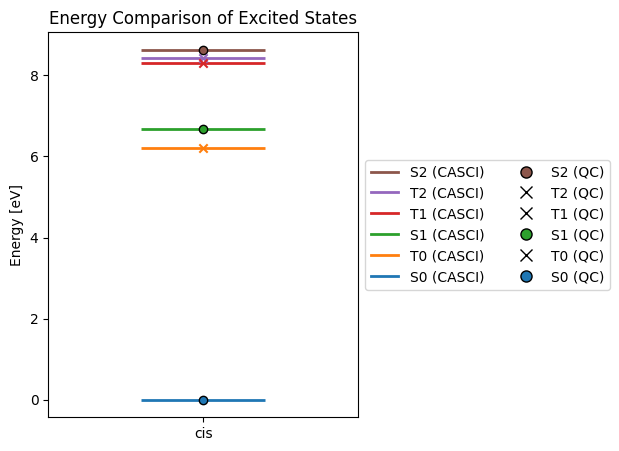

In [8]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

cis_exact = mc.e_tot
cis_qc    = qsci(hamiltonian, fixed_state, sampler, TOTAL_SHOTS, BASIS_STATES)[0]

multiplicity_info = [round(mc.fcisolver.spin_square(mc.ci[i], mc.ncas, mc.nelecas)[1]) for i in range(mc.fcisolver.nstates)]

labels = []
markers = []
colors = plt.cm.tab10.colors
count_dict = {}

for mult in multiplicity_info:
    if mult == 1:
        prefix, marker = "S", "o"
    elif mult == 3:
        prefix, marker = "T", "x"
    elif mult == 5:
        prefix, marker = "Q", "^"
    elif mult == 7:
        prefix, marker = "H", "s"
    else:
        prefix, marker = f"M{mult}", "d"

    idx = count_dict.get(prefix, 0)
    labels.append(f"{prefix}{idx}")
    markers.append(marker)
    count_dict[prefix] = idx + 1

cis_exact = (cis_exact - cis_exact[0])*27.21 # Change to eV
cis_qc = (cis_qc - cis_qc[0])*27.21

# Sort by energy, and make label from down to up
order = np.argsort(cis_exact)[::-1]

labels   = [labels[i] for i in order]
markers  = [markers[i] for i in order]
cis_exact = cis_exact[order]
cis_qc    = cis_qc[order]
colors   = [colors[i] for i in order]

fig, ax = plt.subplots(figsize=(4, 5))
x_pos = 1.0
width = 0.08

for i in range(len(labels)):
    ax.hlines(cis_exact[i], x_pos - width, x_pos + width, color=colors[i], lw=2)
    ax.scatter(x_pos, cis_qc[i], color=colors[i], edgecolor='black', marker=markers[i], zorder=5)

handles_casci = [Line2D([0], [0], color=c, lw=2, label=f"{l} (CASCI)")
                 for c, l in zip(colors, labels)]
handles_qc = [Line2D([0], [0], color=c, marker=m, linestyle='None',
                     markeredgecolor="black", markersize=8, label=f"{l} (QC)")
              for c, m, l in zip(colors, markers, labels)]

handles = handles_casci + handles_qc

ax.legend(handles=handles, ncol=2, loc='center left', bbox_to_anchor=(1.0, 0.5))

ax.set_xlim(0.8, 1.2)
ax.set_xticks([x_pos])
ax.set_xticklabels(["cis"])
ax.set_ylabel("Energy [eV]")
ax.set_title("Energy Comparison of Excited States")

plt.show()


## Appendix (A): Jordan-Wigner mapping

In order to map a fermionic Hamiltonian into a qubit Hamiltonian that can be implemented on quantum circuits, we use the **Jordan–Wigner transformation**.  
This transformation maps fermionic creation and annihilation operators into tensor products of Pauli operators.  

For a system with $N$ spin-orbitals, the mapping is given by


$a_p^\dagger \;\;\mapsto\;\; \frac{1}{2}\Bigg(\prod_{j=0}^{p-1} Z_j\Bigg)(X_p - iY_p),$



$a_p \;\;\mapsto\;\; \frac{1}{2}\Bigg(\prod_{j=0}^{p-1} Z_j\Bigg)(X_p + iY_p),$


where $a_p^\dagger$ and $a_p$ are fermionic creation and annihilation operators acting on orbital $p$, and $X_p, Y_p, Z_p$ are Pauli matrices acting on the $p$-th qubit.  
The string of $Z$ operators ensures the correct fermionic anti-commutation relations.  


## Appendix (B): Configuration Interaction Single and Double (CISD)

Before we dive into CISD result, we can first compute how many states can it be (Since CI doesn't have size extensivity, it has a maximum number of states). And then we can use CASCI again to check the error of CISD.

### Maximum CISD size:
1. Compute how many empty orbitals: `occ` and how many occupied orbitals: `un_occ`.
2. Single excitation: 2 $\times$ $\binom{occ}{1}$ $\times$ $\binom{unocc}{1}$, Each select one electron from empty orbitals and occupied orbitals.
3. Double excitation (1): Two electrons are excited from different orbitals, $(\binom{occ}{1} \ \times \ \binom{unocc}{1})^2$
4. Double excitation (2): Two electrons are excited from the same orbital, 2 $\times$ $\binom{occ}{2}$ $\times$ $\binom{unocc}{2}$

In practice, we compute CISD by PySCF we should note that CISD size given by PySCF is typically smaller than the combinatorial count, because PySCF works with unique Slater determinants at fixed spin projection, eliminating redundant excitations.

In [9]:
from scipy.special import binom
from quri_parts.chem.mol import ActiveSpace

def get_cisd_size(active_space: ActiveSpace) -> int:
    n_orb = active_space.n_active_orb
    occ = active_space.n_active_ele // 2
    un_occ = n_orb - occ
    single = binom(occ, 1) * binom(un_occ, 1) * 2
    double = binom(occ, 2) * binom(un_occ, 2) * 2 + (binom(occ, 1) * binom(un_occ, 1))**2
    return int(1 + single + double)

cisd_size = get_cisd_size(active_space)
print(f"Maximum CISD size: {cisd_size}")

Maximum CISD size: 27


In PySCF, the CISD expansion spans 15 unique Slater determinants.

In [41]:
cisd_solver = ci.CISD(mf, forzen_orbs)
cisd_solver.nstates = cisd_size
cisd_energy = cisd_solver.run().e_tot

print(f"\nEnergy from CISD: {cisd_energy*27.21} eV")

RCISD root 0  E = -562.0576692731057
RCISD root 1  E = -561.8097497841378
RCISD root 2  E = -561.7386761840065
RCISD root 3  E = -561.6820484814332
RCISD root 4  E = -561.6419212432804
RCISD root 5  E = -561.5697350286234
RCISD root 6  E = -561.4675268864693
RCISD root 7  E = -561.4306455754565
RCISD root 8  E = -561.4040337512311
RCISD root 9  E = -561.3631207402699
RCISD root 10  E = -561.3208463907085
RCISD root 11  E = -561.2659553058691
RCISD root 12  E = -561.2197824358046
RCISD root 13  E = -561.1547452687606
RCISD root 14  E = -561.073834207525

Energy from CISD: [-15293.58918092 -15286.84329163 -15284.90937897 -15283.36853918
 -15282.27667703 -15280.31249013 -15277.53140658 -15276.52786611
 -15275.80375837 -15274.69051534 -15273.54023029 -15272.04664387
 -15270.79028008 -15269.02061876 -15266.81902879] eV


In [25]:
cisd_size = 15

### Comparison of CISD energies with CASCI and QSCI

For reference, we compute CASCI with the same configuration size as CISD.
We also apply the QSCI procedure under the same configuration for a direct comparison.

In [42]:
mc = mcscf.CASCI(mf, active_space.n_active_orb, active_space.n_active_ele)
mc.fcisolver.nstates = cisd_size
mc.kernel(verbose=0)

print(f"\nEnergy from CASCI: {mc.e_tot*27.21} eV")

CASCI state   0  E = -562.057671219960  E(CI) = -2.20745364895095  S^2 = 0.0000000
CASCI state   1  E = -561.829824515089  E(CI) = -1.97960694408050  S^2 = 2.0000000
CASCI state   2  E = -561.812652554590  E(CI) = -1.96243498358137  S^2 = 0.0000000
CASCI state   3  E = -561.752682574615  E(CI) = -1.90246500360570  S^2 = 2.0000000
CASCI state   4  E = -561.747970360661  E(CI) = -1.89775278965180  S^2 = 2.0000000
CASCI state   5  E = -561.740607983116  E(CI) = -1.89039041210685  S^2 = 0.0000000
CASCI state   6  E = -561.734241645805  E(CI) = -1.88402407479612  S^2 = 2.0000000
CASCI state   7  E = -561.682073804745  E(CI) = -1.83185623373629  S^2 = 0.0000000
CASCI state   8  E = -561.642062543431  E(CI) = -1.79184497242204  S^2 = 0.0000000
CASCI state   9  E = -561.607468237756  E(CI) = -1.75725066674670  S^2 = 6.0000000
CASCI state  10  E = -561.586873951964  E(CI) = -1.73665638095520  S^2 = 2.0000000
CASCI state  11  E = -561.576589164516  E(CI) = -1.72637159350666  S^2 = 2.0000000
CASC

In [ ]:
from scipy.optimize import minimize

sampler = create_qulacs_general_vector_sampler()

exc_masks = [0 for _ in range(cisd_size-1)]
fixed_state = [uccsd_bound_state]

for exc_mask in exc_masks:
    bits = (2**active_space.n_active_ele - 1) ^ exc_mask
    cost = get_cost(
        exc_bits=bits,
        sampler=sampler,
        hamiltonian=hamiltonian,
        fixed_state=fixed_state,
        BASIS_STATES=cisd_size,
    )

    bounds = [(-10**-1, 10**-1) for _ in range(uccsd.parameter_count)]
    sol = minimize(
        cost,
        x0=np.random.uniform(-10**-2, 10**-2, uccsd.parameter_count),
        method="COBYLA",
        bounds=bounds,
        options={"maxiter": 50, "disp": True}
    )

    excited_state = quantum_state(
        active_space.n_active_orb * 2, bits=bits, circuit=uccsd.bind_parameters(sol.x)
    )
    fixed_state.append(create_state(bits, params=sol.x))



   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   50   F =-1.123883E+03    MAXCV = 1.164770E-02
   X =-1.111968E-01  -1.100457E-01  -1.076639E-01  -1.000000E-01  -5.762703E-02
       6.546894E-02  -9.646421E-02   5.226340E-02  -7.227194E-02  -1.116477E-01
      -9.670644E-02  -9.531221E-02   6.294035E-02   8.306630E-02

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   50   F =-1.685694E+03    MAXCV = 0.000000E+00
   X = 5.267167E-03  -5.480466E-03  -7.074251E-03  -1.202343E-02  -1.313867E-02
       5.454317E-03  -7.065425E-03   4.478184E-02   8.688552E-02  -5.666565E-02
      -4.774242E-03  -2.916518E-02   4.494122E-02  -1.130773E-02

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   50   F =-2.247441E+03    MAXCV = 2.359224E-16
   X =-1.000000E-01  -1.000000E-01   1.000000E-01  -1.000000E-01  -5.092225E-02
      -2.151347E-02   8.757260E-02  -2.413164E-02  -9.07

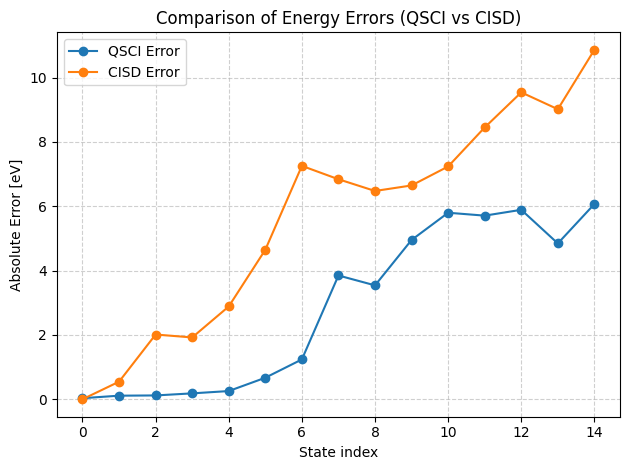

In [43]:

plt.plot(np.abs(mc.e_tot - qsci(hamiltonian, fixed_state, sampler, TOTAL_SHOTS, num_states_pick_out=15)[0])*27.21, marker='o', linestyle='-', label='QSCI Error')
plt.plot(np.abs(mc.e_tot - cisd_energy)*27.21, marker='o', linestyle='-', label='CISD Error')

plt.title("Comparison of Energy Errors (QSCI vs CISD)")
plt.xlabel("State index")
plt.ylabel("Absolute Error [eV]")

plt.legend()

plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

From the above result, we observed that QSCI can get more accurate energies than CISD under the same configuration size.